In [1]:
! pip install py7zr pandas


   ---------------------------------------- 0.0/69.7 kB ? eta -:--:--
   ---------------------------------------- 69.7/69.7 kB 3.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/369.1 kB ? eta -:--:--
   ------------------------------------ --- 337.9/369.1 kB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 369.1/369.1 kB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.8 MB 5.0 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.8 MB 6.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.8 MB 6.6 MB/s eta 0:00:01
   ------------------------- -------------- 1.2/1.8 MB 6.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.5/1.8 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 6.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.6 kB ? eta -:--:--
   -----------------------

In [27]:
import requests
import pandas as pd
import numpy as np
import gzip
import py7zr
import io
import seaborn as sns

In [28]:
#Fonction pour récupérer les données d'un fichier csv.gz ( pour les données météorologiques )
def recuperer_donnees_gz(dataset_id, fichier_csv, sep):
    """
    Cette fonction télécharge les données d'un fichier CSV.GZ à partir d'une URL et les charge dans un DataFrame pandas.
    
    Paramètres:
    dataset_id (str): identifiant du fichier CSV.GZ.
    fichier_csv (str): Le nom du fichier CSV.GZ à enregistrer localement.
    sep ( str ) : le séparateur à utiliser
    
    Retourne:
    DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """

    # URL de base pour accéder à l'API
    base_api = "https://www.data.gouv.fr/api/1/"

    # Chemin pour accéder aux enregistrements du dataset
    key_api = "datasets/r/"

    # Construction de l'URL complète
    url = f"{base_api}{key_api}{dataset_id}"


    response = requests.get(url)
    response.raise_for_status()
    with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz:
        df = pd.read_csv(gz, sep = sep)
    
    return df

## DAILY SWI

In [29]:
quot_25 = recuperer_donnees_gz('92065ec0-ea6f-4f5e-8827-4344179c0a7f', 'QUOT_2020-2025', ';')
quot_25.tail()

,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,Q,DLI,SSI,...,RESR_NEIGE6,HTEURNEIGE,HTEURNEIGE6,HTEURNEIGEX,SNOW_FRAC,ECOULEMENT,WG_RACINE,WGI_RACINE,TINF_H,TSUP_H
21079847,11960,17450,20251027,0.0,0.0,15.5,2.4,6.076,2695.1,1376.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,12.1,20.3
21079848,11960,17450,20251028,0.0,0.1,15.4,2.1,7.500,2877.0,1195.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,11.2,22.5
21079849,11960,17450,20251029,0.0,1.0,17.0,2.9,9.242,3156.7,641.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,12.0,22.7
21079850,11960,17450,20251030,0.0,3.3,17.7,1.6,11.344,3426.6,178.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.205,0.0,16.5,18.9
21079851,11960,17450,20251031,0.0,0.4,17.9,1.6,11.022,3174.7,859.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.207,0.0,16.0,21.5


In [32]:
liste_id=['eb0d6e42-cee6-4d7c-bc5b-646be4ced72e','33417617-c0dd-4513-804e-c3f563cb81b4','08ad5936-cb9e-4284-a6fc-36b29aca9607',
          'ad584d65-7d2d-4ff1-bc63-4f93357ed196','10d2ce77-5c3b-44f8-bb46-4df27ed48595','da6cd598-498b-4e39-96ea-fae89a4a8a46',
          '92065ec0-ea6f-4f5e-8827-4344179c0a7f','adcca99a-6db0-495a-869f-40c888174a57']
# année=[1960-1969,1970-1979,1980-1989,'1990-1999',2000-2009,2010-2019,2020-202510,20251001-20251107]

In [95]:
def compute_mean_swi(data_id, value_cols=None):
    df= recuperer_donnees_gz(data_id, '', ';')
    df["YEAR"] = df["DATE"].astype(str).str[:4].astype(int)
    df["MONTH"] = df["DATE"].astype(str).str[5:6].astype(int)
    df=df.drop("DATE",axis=1)
    # Colonnes clés
    group_cols = ["LAMBX", "LAMBY", "YEAR", "MONTH"]

    # Déterminer les colonnes à moyenner
    if value_cols is None:
        # On prend toutes les colonnes numériques sauf YEAR/MONTH/LAMBX/LAMBY
        exclude = set(group_cols)
        num_cols = [c for c in df.select_dtypes(include="number").columns
                    if c not in exclude]
        value_cols = num_cols
     # Agrégation
    out = (
        df[group_cols + value_cols]
        .groupby(group_cols, as_index=False)
        .mean()
    )
     # Recréer une DATE mensuelle (au 1er jour du mois)
    
    return out

data20_25=compute_mean_swi(data_id='92065ec0-ea6f-4f5e-8827-4344179c0a7f')
data20_25.head()

MemoryError: Unable to allocate 4.08 GiB for an array with shape (26, 21079852) and data type float64

In [30]:
# Création d'une colonne YEAR
quot_25["YEAR"] = quot_25["DATE"].astype(str).str[:4].astype(int)

In [ ]:
quot_25[quot_25["YEAR"]==2021]["LAMBX"].unique() # ces coordonnées de LAMBert X sur lesquels sont collectés le SWI ne correpondent pas avec ceux du SWI uniforme

array([  600,   760,   840,   920,  1000,  1080,  1160,  1240,  1320,
        1400,  1480,  1560,  1640,  1720,  1800,  1880,  1960,  2040,
        2120,  2200,  2280,  2360,  2440,  2520,  2600,  2680,  2760,
        2840,  2920,  3000,  3080,  3160,  3240,  3320,  3400,  3480,
        3560,  3640,  3720,  3800,  3880,  3960,  4040,  4120,  4200,
        4280,  4360,  4440,  4520,  4600,  4680,  4760,  4840,  4920,
        5000,  5080,  5160,  5240,  5320,  5400,  5480,  5560,  5640,
        5720,  5800,  5880,  5960,  6040,  6120,  6200,  6280,  6360,
        6440,  6520,  6600,  6680,  6760,  6840,  6920,  7000,  7080,
        7160,  7240,  7320,  7400,  7480,  7560,  7640,  7720,  7800,
        7880,  7960,  8040,  8120,  8200,  8280,  8360,  8440,  8520,
        8600,  8680,  8760,  8840,  8920,  9000,  9080,  9160,  9240,
        9320,  9400,  9480,  9560,  9640,  9720,  9800,  9880,  9960,
       10040, 10120, 10200, 10280, 10360, 10440, 10520, 10600, 10680,
       10760, 10840,

In [26]:
quot_10_19 = recuperer_donnees_gz('da6cd598-498b-4e39-96ea-fae89a4a8a46', 'QUOT_2010-2019', ';')
quot_10_19.tail()

,LAMBX,LAMBY,DATE,PRENEI,PRELIQ,T,FF,Q,DLI,SSI,...,RESR_NEIGE6,HTEURNEIGE,HTEURNEIGE6,HTEURNEIGEX,SNOW_FRAC,ECOULEMENT,WG_RACINE,WGI_RACINE,TINF_H,TSUP_H
36125579,11960,17450,20191227,0.0,0.0,11.0,3.0,6.396,2714.8,503.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.328,0.0,9.6,15.0
36125580,11960,17450,20191228,0.0,0.0,9.7,2.3,4.937,2630.0,504.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.327,0.0,6.9,14.1
36125581,11960,17450,20191229,0.0,0.0,7.7,3.6,3.942,2371.0,841.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.326,0.0,5.8,12.9
36125582,11960,17450,20191230,0.0,0.0,9.6,4.5,3.653,2338.6,972.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.324,0.0,6.0,12.9
36125583,11960,17450,20191231,0.0,0.0,7.9,1.7,4.301,2418.4,849.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.322,0.0,4.4,12.8


In [27]:
quot_10_19["YEAR"] = quot_10_19["DATE"].astype(str).str[:4].astype(int)

In [ ]:
quot_10_19[quot_10_19["YEAR"]==2011]["LAMBX"].unique()

142

Il faudra repliquer la même chose sur toutes les bases depuis 1958, et fusionner toutes les bases en une seule complète de 1958 à 2025

## SWI Uniforme

In [46]:
import os

# chemin vers le dossier à modifier, mais les données ont stockés dans github (open data donc ca ne dérange pas)
folder_path = "C:/Users/lisaw/Desktop/ENSAE/3A/Machine_learning/Project/MACHINE-LEARNING-FOR-CLIMATE-RISK/Data_swi_uniform"

dfs = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        #print("Lecture :", file_path)
        df = pd.read_csv(file_path, sep=";")
        dfs.append(df)

swi_uniform_df = pd.concat(dfs, ignore_index=True)

print("Fusion terminée")
print(swi_uniform_df.shape)

#swi_uniform_df.to_csv("merged.csv", index=False)


Fusion terminée
(7005180, 5)


In [16]:
swi_uniform_df.head()

,NUMERO,LAMBX,LAMBY,DATE,SWI_UNIF_MENS
0,2,641374,7106309,196001,"0,863"
1,2,641374,7106309,196002,"0,876"
2,2,641374,7106309,196003,"0,856"
3,2,641374,7106309,196004,"0,757"
4,2,641374,7106309,196005,"0,673"


In [19]:
swi_uniform_df[swi_uniform_df["LAMBX"]==11960]

,NUMERO,LAMBX,LAMBY,DATE,SWI_UNIF_MENS


## Données BRGM

In [ ]:
import os
import py7zr
import tempfile
# Décompresser le dossier 

def extract_7z(url: str):
    import requests
    from io import BytesIO

    # Téléchargement
    response = requests.get(url)
    response.raise_for_status()

    # Stockage temporaire
    data = BytesIO(response.content)

    # Extraction
    tmp_dir = tempfile.mkdtemp()
    with py7zr.SevenZipFile(data, mode='r') as z:
        z.extractall(path=tmp_dir)

    return tmp_dir

# Chercher chaque fichier .mbtiles dans le dossier
def find_mbtiles(folder):
    for root, _, files in os.walk(folder):
        for f in files:
            if f.endswith(".mbtiles"):
                return os.path.join(root, f)
    return None



In [3]:
import sqlite3
import pandas as pd

# Lecture de chaque fichier .mbtiles 
def mbtiles_to_dfs(mbtiles_path):
    conn = sqlite3.connect(mbtiles_path)

    # Récupérer la liste des tables
    tables = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    )["name"].tolist()

    dfs = {}
    for t in tables:
        try:
            dfs[t] = pd.read_sql_query(f"SELECT * FROM {t}", conn)
        except Exception as e:
            print("Impossible de lire table", t, ":", e)

    conn.close()
    return dfs

# ressort un dictionnaire de datatframes
def load_mbtiles_7z(url):
    folder = extract_7z(url)
    mbtiles = find_mbtiles(folder)
    if mbtiles is None:
        raise FileNotFoundError("Aucun fichier .mbtiles trouvé")
        
    print("Fichier mbtiles trouvé :", mbtiles)
    dfs = mbtiles_to_dfs(mbtiles)
    return dfs


In [4]:
url = "https://www.data.gouv.fr/api/1/datasets/r/c944be1e-06d6-46be-bf7d-9f9ad2b8ced9"

dfs = load_mbtiles_7z(url)

for name, df in dfs.items():
    print("----", name, "----")
    print(df.head())


Fichier mbtiles trouvé : C:\Users\lisaw\AppData\Local\Temp\tmpsgojxmz2\ExpoArgile_Fxx_4326.mbtiles
---- metadata ----
          name                        value
0         name  ExpoArgile_Fxx_4326.mbtiles
1  description  ExpoArgile_Fxx_4326.mbtiles
2      version                            2
3      minzoom                            2
4      maxzoom                           15
---- map ----
   zoom_level  tile_column  tile_row               tile_id
0           2            1         2   4211784313116134269
1           2            2         2  11520501979463196428
2           3            4         4  16037601933804047707
3           3            3         5  10112098421134192041
4           3            4         5   4502018209664967852
---- images ----
   zoom_level                                          tile_data  \
0           2  b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\x13\x9c...   
1           2  b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x02\x13\x8c...   
2           3  b'\x1f\x8b\x08

In [5]:
dfs["metadata"] # Métadonnées 

,name,value
0,name,ExpoArgile_Fxx_4326.mbtiles
1,description,ExpoArgile_Fxx_4326.mbtiles
2,version,2
3,minzoom,2
4,maxzoom,15
5,center,"1.631470,45.947330,15"
6,bounds,"-5.133440,41.365782,9.559960,51.076490"
7,type,overlay
8,format,pbf
9,generator,tippecanoe v2.22.0


In [6]:
# Conversion du format pbf en geojson
! pip install mapbox-vector-tile mercantile geopandas shapely brotli


In [7]:
import binascii
raw = dfs["images"].iloc[0]["tile_data"]
print(binascii.hexlify(raw[:16]))

# la sortie commence par 1f8b08 qui est la signature d'une compression GZIP

b'1f8b08000000000002139cbd0b8c5557'


In [8]:
import gzip
import mapbox_vector_tile

# Décompression du GZIP
def decode_mvt(tile_data: bytes) -> dict:
    """
    Décompresse GZIP puis décode MVT → dictionnaire Python
    """
    try:
        raw = gzip.decompress(tile_data)
        return mapbox_vector_tile.decode(raw)
    except Exception as e:
        raise RuntimeError(f"Erreur de décompression/décodage MVT: {e}")


In [26]:
# Affichage de la première tuile
sample = dfs["images"].iloc[0]["tile_data"]
decoded = decode_mvt(sample)
decoded


{'ExpoArgile_Fxx_4326': {'extent': 4096,
  'version': 2,
  'features': [{'geometry': {'type': 'Polygon',
     'coordinates': [[[4011, 2613],
       [4011, 2611],
       [4009, 2611],
       [4009, 2613],
       [4011, 2613]]]},
    'properties': {'DPT': '50', 'NIVEAU': 1, 'ALEA': 'Faible'},
    'id': 0,
    'type': 'Feature'},
   {'geometry': {'type': 'Polygon',
     'coordinates': [[[4013, 2611],
       [4013, 2609],
       [4011, 2609],
       [4011, 2611],
       [4013, 2611]]]},
    'properties': {'DPT': '50', 'NIVEAU': 2, 'ALEA': 'Moyen'},
    'id': 0,
    'type': 'Feature'},
   {'geometry': {'type': 'Polygon',
     'coordinates': [[[4015, 2612],
       [4015, 2610],
       [4013, 2610],
       [4013, 2612],
       [4015, 2612]]]},
    'properties': {'DPT': '50', 'NIVEAU': 1, 'ALEA': 'Faible'},
    'id': 0,
    'type': 'Feature'},
   {'geometry': {'type': 'Polygon',
     'coordinates': [[[4017, 2602],
       [4017, 2600],
       [4015, 2600],
       [4015, 2602],
       [4017, 260

In [10]:
# Conversion en GeoJSON (manipulation des données géométrique)
import geopandas as gpd
from shapely.geometry import shape

def mvt_dict_to_gdf(decoded: dict) -> gpd.GeoDataFrame:
    feats = []
    
    for layer_name, layer in decoded.items():
        for feat in layer["features"]:
            geom = shape(feat["geometry"])
            props = feat["properties"]
            props["__layer__"] = layer_name
            props["geometry"] = geom
            feats.append(props)

    return gpd.GeoDataFrame(feats, geometry="geometry", crs="EPSG:3857")


In [ ]:
import pandas as pd

def tiles_to_geodata(map_df, images_df, max_tiles=None):
    merged = map_df.merge(images_df, on=["zoom_level", "tile_id"])
    gdfs = []
    nbad = 0
    
    for i, row in merged.iterrows():
        if max_tiles and i >= max_tiles:
            break

        try:
            decoded = decode_mvt(row["tile_data"])
            gdf = mvt_dict_to_gdf(decoded)
            
            # Ajout champs z/x/y
            gdf["z"] = int(row["zoom_level"])
            gdf["x"] = int(row["tile_column"])
            gdf["y"] = int(row["tile_row"])
            
            gdfs.append(gdf)
        
        except Exception:
            nbad += 1
    
    if not gdfs:
        raise RuntimeError("Aucune tuile lisible !")
    
    print(f"Tuiles décodées : {len(gdfs)} | ignorées : {nbad}")
    return pd.concat(gdfs, ignore_index=True)

gdf_raw = tiles_to_geodata(dfs["map"], dfs["images"], max_tiles=50)
gdf_raw.head()



Tuiles décodées : 50 | ignorées : 0


,DPT,NIVEAU,ALEA,__layer__,geometry,z,x,y
0,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((4011 2613, 4011 2611, 4009 2611, 400...",2,1,2
1,50,2,Moyen,ExpoArgile_Fxx_4326,"POLYGON ((4013 2611, 4013 2609, 4011 2609, 401...",2,1,2
2,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((4015 2612, 4015 2610, 4013 2610, 401...",2,1,2
3,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((4017 2602, 4017 2600, 4015 2600, 401...",2,1,2
4,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((4012 2603, 4012 2604, 4018 2601, 401...",2,1,2


In [12]:
# Reprojection en WGS84
gdf_wgs84 = gdf_raw.to_crs(4326)
gdf_wgs84.head()


,DPT,NIVEAU,ALEA,__layer__,geometry,z,x,y
0,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((0.03603 0.02347, 0.03603 0.02346, 0....",2,1,2
1,50,2,Moyen,ExpoArgile_Fxx_4326,"POLYGON ((0.03605 0.02346, 0.03605 0.02344, 0....",2,1,2
2,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((0.03607 0.02346, 0.03607 0.02345, 0....",2,1,2
3,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((0.03609 0.02337, 0.03609 0.02336, 0....",2,1,2
4,50,1,Faible,ExpoArgile_Fxx_4326,"POLYGON ((0.03604 0.02338, 0.03604 0.02339, 0....",2,1,2


In [14]:
gdf_wgs84["NIVEAU"].unique()

array([1, 2, 3], dtype=int64)

In [16]:
len(gdf_wgs84["DPT"].unique())

95

In [14]:
#Visualisation
layers = gdf_wgs84["__layer__"].unique()
layers


array(['ExpoArgile_Fxx_4326'], dtype=object)

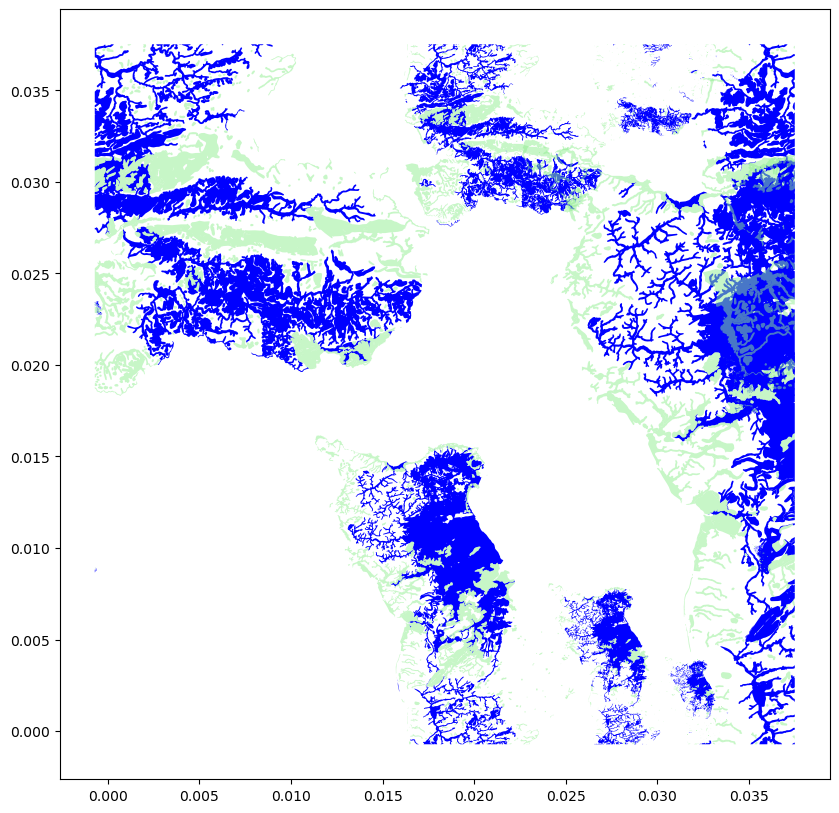

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
#gdf_z = gdf_wgs84[(gdf_wgs84["z"] == 2) & (gdf_wgs84["DPT"] == "50")]
gdf_z = gdf_wgs84[gdf_wgs84["DPT"] == "50"]


mpolygon = gdf_z[gdf_z.geom_type == "MultiPolygon"]
polys = gdf_z[gdf_z.geom_type == "Polygon"]

fig, ax = plt.subplots(figsize=(10,10))
mpolygon.plot(ax=ax, color="blue")
polys.plot(ax=ax, color="lightgreen", alpha=0.5)
plt.show()


#sample = gdf_z.head(1000)
#sample.plot(
#    figsize=(10, 10),
#    column="__layer__",  # color by layer
#    legend=True,
#    alpha=0.7,
#    linewidth=0.5,
#    cmap="tab20"
#)
#plt.show()





In [30]:
print(gdf_wgs84.geom_type.value_counts())

Polygon         173300
MultiPolygon     20129
Name: count, dtype: int64


2762

## Admin express dataset: par territoire de la France Métropolitaine

In [32]:
import os
import py7zr
import tempfile

import os
import py7zr
import tempfile

def extract_local_7z(filepath: str) -> str:
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f"Fichier introuvable : {filepath}")

    tmp_dir = tempfile.mkdtemp()
    print(f"Extraction dans : {tmp_dir}")

    with py7zr.SevenZipFile(filepath, mode='r') as z:
        z.extractall(path=tmp_dir)

    print("Extraction terminée !")
    
    # Liste des fichiers
    print("\n Fichiers extraits :")
    for root, dirs, files in os.walk(tmp_dir):
        for f in files:
            print("   ", os.path.join(root, f))
    
    return tmp_dir


In [33]:
# chemin vers le fichier local(à mettre dans github mais possible que ce soit trop lours pour y être téléchargé, pas encore trouvé d'API)
path_7z = "C:/Users/lisaw/Desktop/ENSAE/3A/Machine_learning/Project/ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15.7z"

folder = extract_local_7z(path_7z)


Extraction dans : C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86
Extraction terminée !

 Fichiers extraits :
    C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86\ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15\ADMIN-EXPRESS\LISEZ-MOI.pdf
    C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86\ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15\ADMIN-EXPRESS\1_DONNEES_LIVRAISON_2025-10-00142\ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15\ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15.gpkg
    C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86\ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15\ADMIN-EXPRESS\2_METADONNEES_LIVRAISON_2025-10-00142\ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15\LISEZ_MOI.txt
    C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86\ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15\ADMIN-EXPRESS\3_SUPPLEMENTS_LIVRAISON_2025-10-00142\ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15\EMPRISE\EMPRISE.cpg
    C:\Users\lisaw\AppData\Local\Temp\tmpk4w7il86\ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15\ADMIN-EXPRESS\3_SUPPLEMENTS_LIVRAISON_2025-10

In [34]:
import geopandas as gpd
# Fichier principal
gpkg_path = "C:/Users/lisaw/AppData/Local/Temp/tmpynaoy8wa/ADMIN-EXPRESS_4-0__GPKG_LAMB93_FXX_2025-10-15/ADMIN-EXPRESS/1_DONNEES_LIVRAISON_2025-10-00142/ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15/ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15.gpkg"

gdf = gpd.read_file(gpkg_path)
gdf.head()


c:\Users\lisaw\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read(
c:\Users\lisaw\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read(
c:\Users\lisaw\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read(
c:\Users\lisaw\anaconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read(
c:\Users\lisaw\anaconda3\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'ADE_4-0_GPKG_LAMB93_FXX-ED2025-10-15.gpkg': 'canton' (default), 'arrondissement', 'arrondissement_municipal', 'chef_lieu_d_arrondissement', 'chef_lieu_d_arrondissement_municipal', 'chef_lieu_de_canton', 'chef_lieu_de_collectivite_territoriale', 'chef_lieu_de_commune', 'chef_lieu_de_commune_a

,cleabs,nom_officiel,nom_officiel_en_majuscules,numero_du_canton,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,composition_du_canton,geometry
0,CANTON__0000000000008611,Migné-Auxances,MIGNE-AUXANCES,11,8611,863,86,75,Commune(s) entière(s),"MULTIPOLYGON (((485821.6 6621174.4, 485792.6 6..."
1,CANTON__0000000000006713,Reichshoffen,REICHSHOFFEN,13,6713,672,67,44,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((1038844.4 6869352.9, 1038825.6..."
2,CANTON__0000000000001810,La Guerche-sur-l'Aubois,LA GUERCHE-SUR-L'AUBOIS,10,1810,182,18,24,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((676322.6 6650709, 676352.3 665..."
3,CANTON__0000000000003916,Coteaux du Lizon,COTEAUX DU LIZON,16,3916,393,39,27,Commune(s) entière(s),"MULTIPOLYGON (((910159.4 6577137.8, 910114.2 6..."
4,CANTON__0000000000005213,Saint-Dizier-1,SAINT-DIZIER-1,13,5213,523,52,44,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((837589.8 6826780.5, 837574.4 6..."


In [25]:
len(gdf["code_insee_du_departement"].unique())
# 95 département, correspond avec les données du niveau d'argile

95

In [ ]:
### Jointure des points de la grille SAFRAN aux communes

In [ ]:
# base des communes
gdf_communes = gpd.read_file(gpkg_path, layer="commune").to_crs(2154)
#base des départements
gdf_deps      = gpd.read_file(gpkg_path, layer="departement").to_crs(2154)
gdf_deps.head()

,cleabs,nom_officiel,nom_officiel_en_majuscules,code_insee,code_insee_de_la_region,code_siren,geometry
0,DEPARTEM0000000000000007,Ardèche,ARDECHE,07,84,220700017,"MULTIPOLYGON (((814943.8 6354890.8, 814934.9 6..."
1,DEPARTEM0000000000000063,Puy-de-Dôme,PUY-DE-DOME,63,84,226300010,"MULTIPOLYGON (((660731 6495387.9, 660724.7 649..."
2,DEPARTEM0000000000000076,Seine-Maritime,SEINE-MARITIME,76,28,227605409,"MULTIPOLYGON (((534110.5 6925790.5, 534107 692..."
3,DEPARTEM0000000000000017,Charente-Maritime,CHARENTE-MARITIME,17,75,221700016,"MULTIPOLYGON (((371394.3 6531809.7, 371394.5 6..."
4,DEPARTEM0000000000000075,Paris,PARIS,75,11,227500055,"MULTIPOLYGON (((651261.3 6866999, 651268.8 686..."


In [ ]:
# lien à modifier, les données sont stockées sur le repo
# utilisation de la longitude et de la latitude puis conversion en Lambert-93 (EPSG:2154) car les points de la grille utilisée n'ont pas les mêmes echelles que celles de ADMIN-EXPRESS
df_safran=pd.read_csv("C:/Users/lisaw/Desktop/ENSAE/3A/Machine_learning/Project/MACHINE-LEARNING-FOR-CLIMATE-RISK/coordonnees_grille_safran_lambert-2-etendu.csv", sep=";")
df_safran["LON_DG"] = df_safran["LON_DG"].astype(str).str.replace(",", ".", regex=False)
df_safran["LAT_DG"] = df_safran["LAT_DG"].astype(str).str.replace(",", ".", regex=False)
gdf_pts = gpd.GeoDataFrame(
    df_safran.copy(),
    geometry=gpd.points_from_xy(df_safran["LON_DG"], df_safran["LAT_DG"]),
    crs=4326
).to_crs(2154)
gdf_pts.head()

,LAMBX (hm),LAMBY (hm),LAT_DG,LON_DG,geometry
0,600,24010,48.3822,-4.96118,POINT (111539.179 6838790.165)
1,760,24170,48.5386,-4.76561,POINT (127654.757 6854651.667)
2,760,24090,48.467,-4.75585,POINT (127591.268 6846660.146)
3,760,24010,48.3953,-4.74612,POINT (127526.489 6838658.116)
4,760,23930,48.3237,-4.73641,POINT (127463.328 6830667.619)


In [59]:
# --- 3) Jointure spatiale point->commune
# nécessite shapely>=2, et une sindex (rtree/pygeos) pour la perf
pts_communes = gpd.sjoin(gdf_pts, gdf_communes[["code_insee","nom_officiel","geometry"]],
                         predicate="within", how="left")
pts_communes.head()

,LAMBX (hm),LAMBY (hm),LAT_DG,LON_DG,geometry,index_right,code_insee,nom_officiel
0,600,24010,48.3822,-4.96118,POINT (111539.179 6838790.165),NaN,NaN,NaN
1,760,24170,48.5386,-4.76561,POINT (127654.757 6854651.667),NaN,NaN,NaN
2,760,24090,48.467,-4.75585,POINT (127591.268 6846660.146),NaN,NaN,NaN
3,760,24010,48.3953,-4.74612,POINT (127526.489 6838658.116),10419.0,29201,Ploumoguer
4,760,23930,48.3237,-4.73641,POINT (127463.328 6830667.619),NaN,NaN,NaN


In [63]:
pts_communes["LAMBX"]=pts_communes["LAMBX (hm)"]
pts_communes["LAMBY"]=pts_communes["LAMBY (hm)"]
cols_from_t2 = ["LAMBX", "LAMBY", "geometry", "code_insee", "nom_officiel"]

# éviter les doublons de clés côté table2
t2_keys_unique = pts_communes[cols_from_t2].drop_duplicates(subset=["LAMBX", "LAMBY"])

# merge (left join) sur le couple (LAMBX, LAMBY)
merged =quot_25.merge(t2_keys_unique, on=["LAMBX", "LAMBY"], how="left")

In [ ]:
# Coordonnées à retirer car ils ne correspondents pas aux points terrestres de la France métropolitaine (pas de correspondance avec les communes en France)
pts_communes[pd.isna(pts_communes["code_insee"])][["LAMBX","LAMBY"]]

,LAMBX,LAMBY
0,600,24010
1,760,24170
2,760,24090
4,760,23930
9,840,23930
...,...,...
9882,11880,16810
9885,11880,16570
9886,11960,17450
9887,11960,17290


In [90]:
# Points à utilser pour la jointure avec les données du swi journalier
pts_communes_new=pts_communes.loc[pts_communes["code_insee"].notna(), ["LAMBX", "LAMBY","code_insee","nom_officiel"]]
pts_communes_new.head()

,LAMBX,LAMBY,code_insee,nom_officiel
3,760,24010,29201,Ploumoguer
5,760,23610,29168,Plogoff
6,840,24170,29178,Ploudalmézeau
7,840,24090,29119,Lanrivoaré
8,840,24010,29130,Locmaria-Plouzané


In [ ]:
### Jointure des données du swi uniforme aux communes